# Exploration of API Data
First look at minutly data of Fronius Solar API.

## Prerequisits
- localize timestamps to "Europe/Berlin"
- transform data to kwh

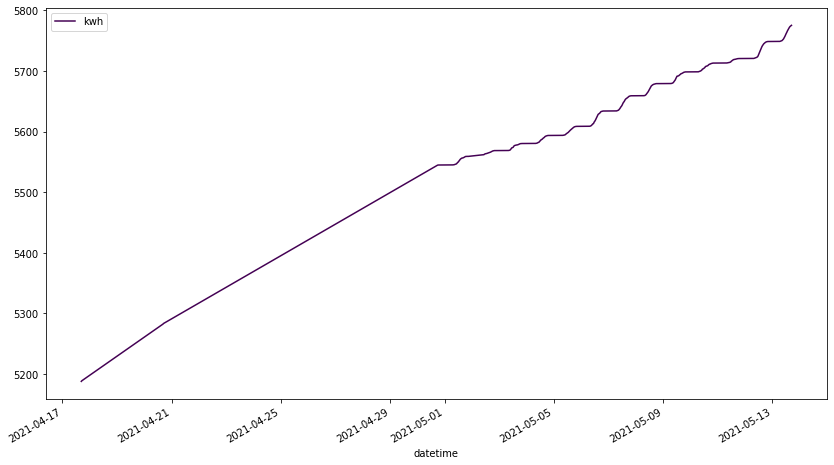

,kwh
datetime,
2021-04-17 16:41:18,5187.73
2021-04-17 17:15:05,5188.91
2021-04-20 16:36:18,5282.48
2021-04-20 16:55:12,5283.25
2021-04-30 17:33:10,5544.48
...,...
2021-05-13 16:57:08,5775.35
2021-05-13 16:58:08,5775.37
2021-05-13 16:59:08,5775.39


In [1]:
import toml
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (14, 8)

conf = '../../conf.toml'
conn = 'postgresql+psycopg2://{}:{}@{}:{}/{}'

def group_time(df, freq, date_format='%Y-%m-%d %H:%M:%S', kind='bar'):
    df = df.groupby(pd.Grouper(freq=freq)).sum()
    df.index = df.index.strftime(date_format=date_format)
    df.plot(kind=kind, colormap='viridis')
    plt.xticks(rotation=45)
    plt.show()
    return df

conf = toml.load(conf)
conf = conf['database']
conf = conf['pi']

conn = conn.format(conf['user'],
                   conf['password'],
                   conf['host'],
                   conf['port'],
                   conf['name'])
conn = sqlalchemy.create_engine(conn)
conn = conn.connect()

kwh = pd.read_sql('select * from energy_minute', conn, 'datetime')

kwh.index = pd.to_datetime(kwh.index, unit='s', utc=True)
kwh.index = kwh.index.tz_convert('Europe/Berlin')
kwh.index = kwh.index.tz_localize(None)

kwh = kwh / 1000
kwh = kwh.rename(columns={'wh': 'kwh'})

kwh.plot(colormap='viridis')

plt.show()
kwh

## Missing Values
Since May 3 the collection runs without major issues. After that the
API throws at some points still an error, but these are not so dramatic.

In [2]:
index = pd.date_range(kwh.index[0], kwh.index[-1], freq='min').round('min')
nan = pd.DataFrame(index=index, columns=['kwh'])

kwh.index = kwh.index.round('min')
nan['kwh'] = kwh

nan = nan[nan.kwh.isna() & (nan.index.hour > 5) & (nan.index.hour < 21)]
nan = nan.isna().groupby(pd.Grouper(freq='d')).count()
nan

,kwh
2021-04-17,257
2021-04-18,900
2021-04-19,900
2021-04-20,898
2021-04-21,900
2021-04-22,900
2021-04-23,900
2021-04-24,900
2021-04-25,900
2021-04-26,900


## First Differences
- Calculate energy produced in one minute.
- Focus on days with few missing values.

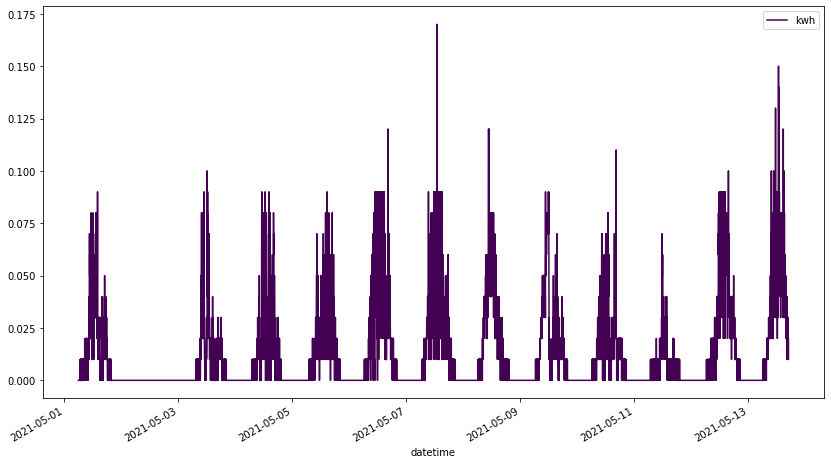

,kwh
datetime,
2021-05-01 06:00:00,0.00
2021-05-01 06:01:00,0.00
2021-05-01 06:02:00,0.00
2021-05-01 06:03:00,0.00
2021-05-01 06:04:00,0.00
...,...
2021-05-13 16:57:00,0.02
2021-05-13 16:58:00,0.02
2021-05-13 16:59:00,0.02


In [3]:
dif = kwh.diff()
dif = dif[np.isin(dif.index.date, nan[nan.kwh > 50].index.date, invert=True)]
dif.plot(colormap='viridis')
plt.show()
dif

## Distribution

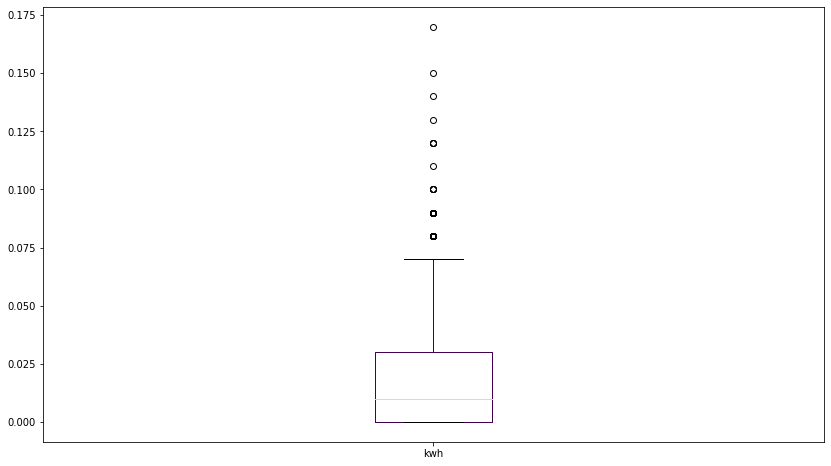

,kwh
count,10439.000000
mean,0.021151
std,0.023324
min,0.000000
25%,0.000000
50%,0.010000
75%,0.030000
max,0.170000


In [4]:
dif.plot.box(colormap='viridis')
plt.show()
dif.describe()

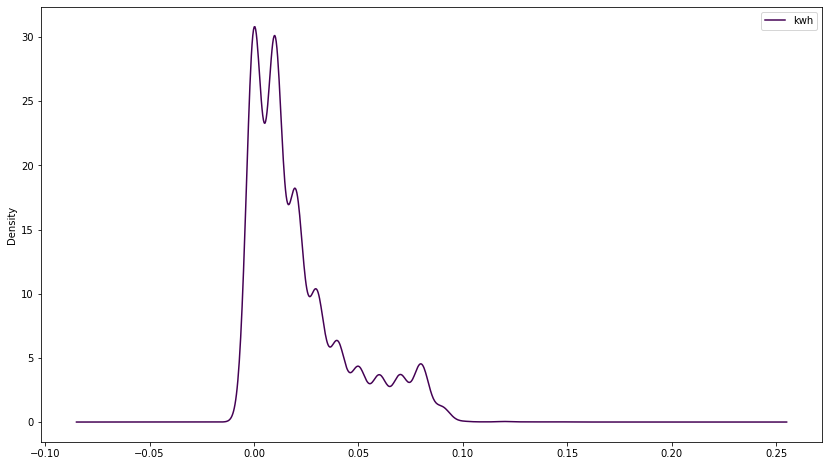

In [5]:
dif.plot.density(colormap='viridis')
plt.show()

## Aggreagate Time Series
### 15 Minutes

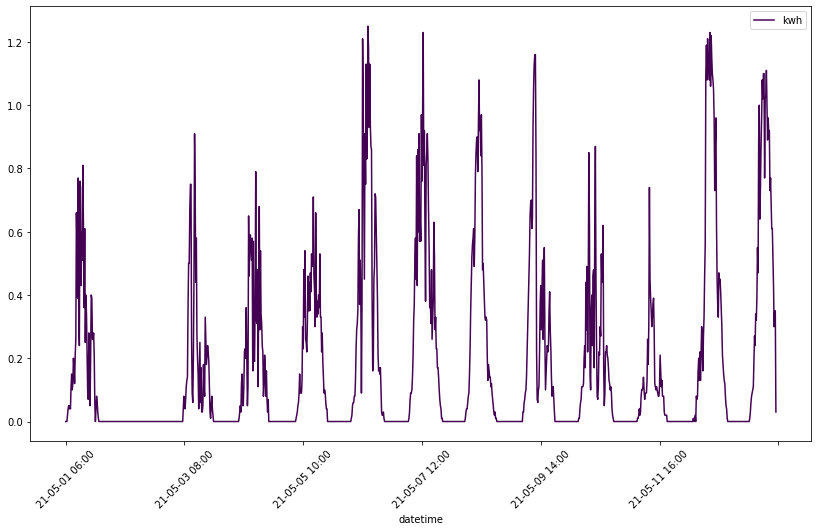

,kwh
datetime,
21-05-01 06:00,0.00
21-05-01 06:15,0.00
21-05-01 06:30,0.00
21-05-01 06:45,0.02
21-05-01 07:00,0.04
...,...
21-05-13 16:00,0.43
21-05-13 16:15,0.30
21-05-13 16:30,0.35


In [6]:
group_time(dif, '15min', '%y-%m-%d %H:%M', 'line')

### Hours

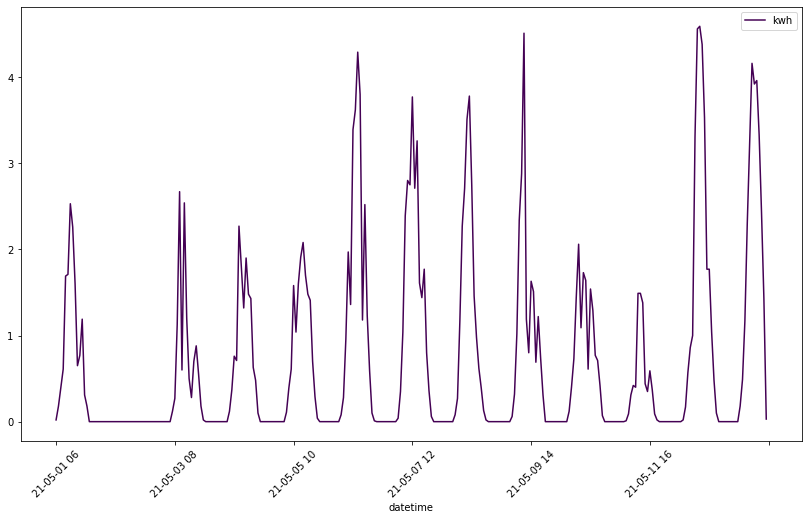

,kwh
datetime,
21-05-01 06,0.02
21-05-01 07,0.18
21-05-01 08,0.40
21-05-01 09,0.61
21-05-01 10,1.69
...,...
21-05-13 13,3.96
21-05-13 14,3.33
21-05-13 15,2.43


In [7]:
group_time(dif, 'H', '%y-%m-%d %H', 'line')

### Days

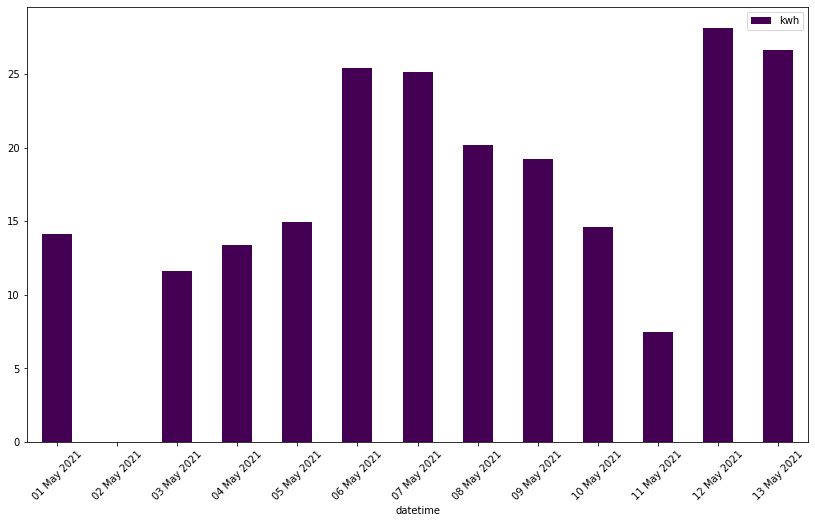

,kwh
datetime,
01 May 2021,14.10
02 May 2021,0.00
03 May 2021,11.64
04 May 2021,13.36
05 May 2021,14.94
06 May 2021,25.38
07 May 2021,25.15
08 May 2021,20.14
09 May 2021,19.22


In [8]:
group_time(dif, 'd', '%d %b %Y')

### Weeks

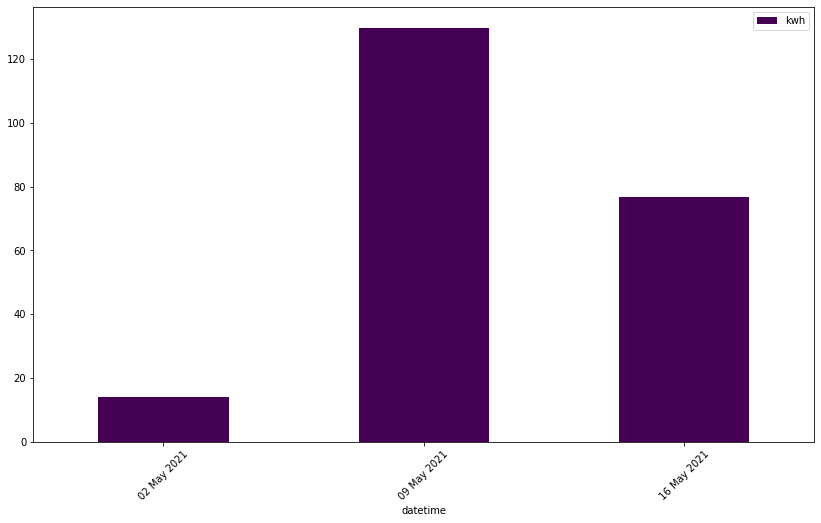

,kwh
datetime,
02 May 2021,14.10
09 May 2021,129.83
16 May 2021,76.87


In [9]:
group_time(dif, 'W', '%d %b %Y')

### Months

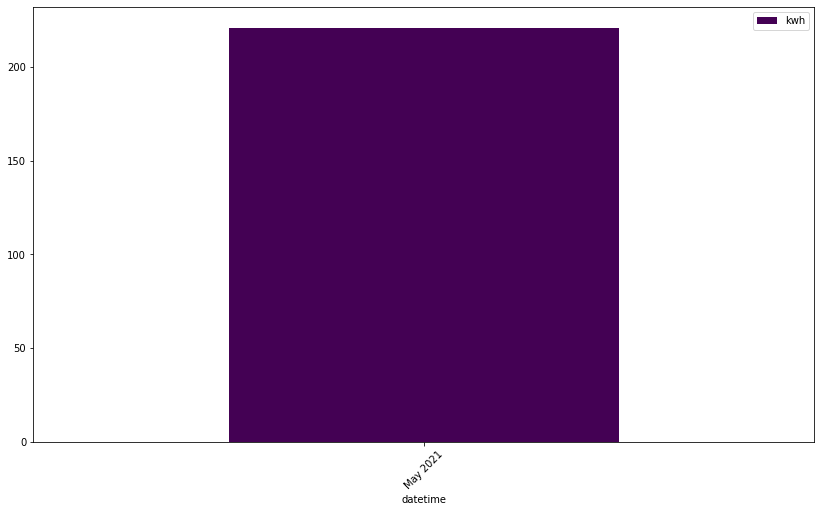

,kwh
datetime,
May 2021,220.8


In [10]:
group_time(dif, 'm', '%b %Y')

### Years

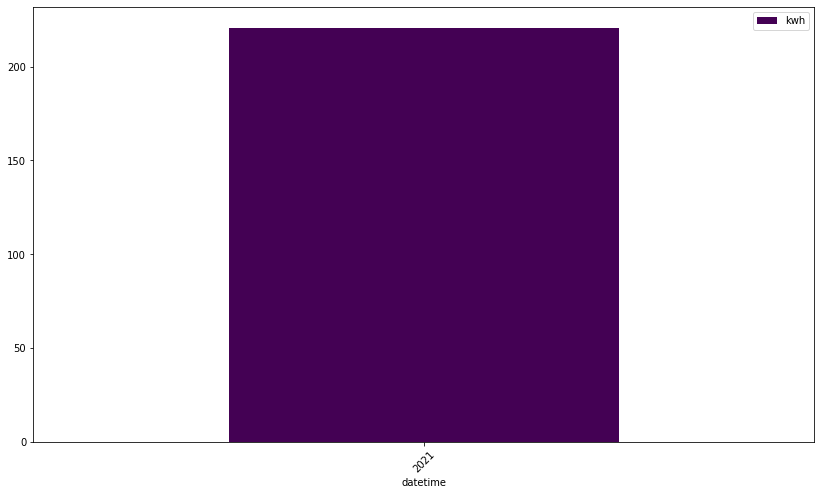

,kwh
datetime,
2021,220.8


In [11]:
group_time(dif, 'y', '%Y')
